# Ekman pumping analysis
## Tech preamble

In [1]:
%matplotlib inline
from pathlib import Path
import os
import gsw
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
import numpy as np
import xarray as xr
import xscale.signal.fitting as xfit
import dask
from dask.distributed import Client
from datetime import timedelta
from datetime import datetime
import xskillscore as xs

In [4]:
ds = xr.open_dataset('/gxfs_work1/geomar/smomw294/iAtlantic/Subprojects/Wind_forcing/data/INALT20_obs_23w_comparison/1_INALT20.L46-KFS101_5d_19580101_19581231_23W_grid_U.nc')

In [5]:
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depthu: 46, time_counter: 73, x: 1, y: 403)
Coordinates:
  * depthu                (depthu) float32 3.047 9.454 ... 5.625e+03 5.875e+03
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 1958-01-03T12:00:00 ....
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthu_bounds         (depthu, axis_nbounds) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    vozocrtx              (time_counter, depthu, y, x) float32 ...
Attributes:
    name:               1_INALT20.L46-KFS101_5d_19580101_19581231_grid_U
    description:        ocean U grid variables
    title:              ocean U grid variables
    Conventions:        CF-1.6
    timeStamp:          2019-Oct-07 04:23:13 GMT
    uuid:               673eee88-50a9-42a0-bd7a-04b21d5b7c20
    NCO:                netCDF Operators version 4.9.3 (Homepage = http://nco...
    history:            Mon Oct  2 16:49:41 2023: ncatted -O -a pi,global,c,c...
    pi:                 Arne Biastoch
    pi_email:           abiastoch@geomar.de
    experiment_name:    $CONF
    experiment_id:      $CASE1
    institution_id:     GEOMAR
    institution:        GEOMAR Helmholtz Centre for Ocean Research
    contributor_name:   Klaus Getzlaff, \n Franziska schwarzkopf,
    contributor_email:  kgetzlaff@geomar.de, \n fschwarzkopf@geomar.de,
    creator_name:       Kristin Burmeister
    creator_email:      kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298
    license:            CC-BY4
    keywords:           Atlantic, ocean-model, high-resolution, temperature, ...
    reference:          Schwarzkopf et al., 2019, https://doi.org/10.5194/gmd...
    terms_of_use:       By using the given data the following terms and condi...

## Dask-jobqueue and clients

In [2]:
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(
    # Dask worker size
    cores=4, memory='24GB',
    processes=1, # Dask workers per job
    # SLURM job script things
    queue='cluster', walltime='00:45:00',
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',
    log_directory='./slurm_logs'
)

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43813 instead
  http_address["port"], self.http_server.port


In [3]:
client = Client(cluster)
# client = Client(n_workers=1, threads_per_worker=8, memory_limit=12e9)

In [4]:
client

Client Scheduler: tcp://172.18.4.13:43599 Dashboard: http://172.18.4.13:43813/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
cluster.adapt(
    minimum=1, maximum=20,
)

## Parameter preamble

In [6]:
calc_JRA = 1 #set 1 if sn_JRA should be recalculated
calc_CORE = 1 #set 1 if sn_CORE should be recalculated
global_data_path = Path("/gxfs_work1/geomar/smomw294/iAtlantic/Subprojects/Wind_forcing/data/INALT20_taux_tauy_10S10N")
in_dir_global_mm = '../'
in_dir_data_mm = 'data/INALT20_wind_forcing_comparison'

JRA_exp_id = "INALT20.L46-KFS10?"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

# chunk sizes
chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = 1
chu_t = 12

# limits wanted
# JRA_tlim = [1996,2018]
# CORE_tlim = [1996,2009]
# lat_lim,lon_lim = [-1.12,5.25],[-23.05,-15]
# lat_lim1,lon_lim2 = [-6,8],[40,35,30,25,20]

# lat_lim=[-6,7.98]
# lon_lims = [-40,-35,-30,-25,-20,-15]

## load YCM
EUC_data_path = Path("../data/INALT20_EUC_calc_transport/")
NEUC_data_path = Path("../data/INALT20_NEUC_calc_transport/")
SEUC_data_path = Path("../data/INALT20_SEUC_calc_transport/")
NECC_data_path = Path("../data/INALT20_NECC_calc_transport/")
nSECu_data_path = Path("../data/INALT20_nSECu_calc_transport/")

In [7]:
nest_prefix_2deg = "2deg_"

JRA_file_y_2deg = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_tauy/{nest_prefix_2deg}{JRA_exp_id}*_windstress_10S10N_65W15E_grid_V.nc")))
JRA_file_x_2deg = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_taux/{nest_prefix_2deg}{JRA_exp_id}*_windstress_10S10N_65W15E_grid_U.nc")))
CORE_file_y_2deg = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_tauy/{nest_prefix_2deg}{CORE_exp_id}*_windstress_10S10N_65W15E_grid_V.nc")))
CORE_file_x_2deg = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_taux/{nest_prefix_2deg}{CORE_exp_id}*_windstress_10S10N_65W15E_grid_U.nc")))

print(f"Found {len(JRA_file_y_2deg)} JRA Y files, {len(JRA_file_x_2deg)} JRA X files, {len(CORE_file_y_2deg)} CORE Y files, {len(CORE_file_x_2deg)} CORE X files")

Found 61 JRA Y files, 61 JRA X files, 52 CORE Y files, 52 CORE X files


In [8]:
# Find data files
aux_files = list(sorted(
        (global_data_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

print(f"Found {len(aux_files)} mesh/mask files")

Found 1 mesh/mask files


In [9]:
JRA_file_y = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_tauy/{nest_prefix}{JRA_exp_id}*_windstress_10S10N_65W15E_grid_V.nc")))
JRA_file_x = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_taux/{nest_prefix}{JRA_exp_id}*_windstress_10S10N_65W15E_grid_U.nc")))
CORE_file_y = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_tauy/{nest_prefix}{CORE_exp_id}*_windstress_10S10N_65W15E_grid_V.nc")))
CORE_file_x = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_taux/{nest_prefix}{CORE_exp_id}*_windstress_10S10N_65W15E_grid_U.nc")))

print(f"Found {len(JRA_file_y)} JRA Y files, {len(JRA_file_x)} JRA X files, {len(CORE_file_y)} CORE Y files, {len(CORE_file_x)} CORE X files")

Found 61 JRA Y files, 61 JRA X files, 52 CORE Y files, 52 CORE X files


In [10]:
script_name = "INALT20_wind_forcing_Ekman"
out_dir_data = f"../data/{script_name}/"
Path(out_dir_data).mkdir(parents=True, exist_ok=True)


In [11]:
out_dir_fig = f"../figures/{script_name}/"
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
# fig_name_1 = f"INALT20_wind_curl_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
# fig_name_2 = f"INALT20_wind_curl_SAH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
# fig_name_3 = f"INALT20_wind_taux_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
# fig_format = ".png"
# savefig = 1

## Figure settings

In [12]:
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

## Functions

In [13]:
def load_2deg_mm_data(JRA_file,CORE_file):
#     JRA_file,CORE_file,ds_mesh,lat_lim,grid = JRA_file_y,CORE_file_y,ds_mesh,lat_lim,'V'
    ds_JRA = (xr.open_mfdataset(
            JRA_file,
            combine='by_coords',
        chunks={"time_counter":chu_t, 
              "lat":chu_y,"lon":chu_x},
            decode_cf=True))

    
    ds_CORE = (xr.open_mfdataset(
            CORE_file,
            combine='by_coords',
            decode_cf=True,
        chunks={"time_counter":chu_t, 
              "lat":chu_y,"lon":chu_x},
        ))
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice(None,'2009')).time_counter

    with xr.set_options(keep_attrs=True):
        ds = xr.concat([ds_JRA,ds_CORE],
                        'forcings')

    ds.coords['forcings'] = (['forcings'],['JRA','CORE'],)

    return ds

In [14]:
def load_windstress_5d(data_path,grid,JRA_tlim,CORE_tlim,ds_mesh):
    JRA_exp_id = "INALT20.L46-KFS10?"
    CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

    temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
    nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

    JRA_files = list(sorted(
        (data_path).glob(
            f"{nest_prefix}{JRA_exp_id}{temp_res}*[{grid}].nc")
    ))

    CORE_files = list(sorted(
        (data_path ).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*[{grid}].nc"
        )
    ))
    
    ## restrict time period
    tlim = np.array(JRA_tlim) - 1958
    JRA_files = JRA_files[tlim[0]:tlim[1]+1]

    tlim = np.array(CORE_tlim) - 1958
    CORE_files = CORE_files[tlim[0]:tlim[1]+1]

    print(f"Found {len(CORE_files)} CORE {grid} files and {len(JRA_files)} JRA {grid} files.")
    
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        combine='by_coords',
        decode_cf=True,
        chunks={"time_counter":chu_t, 
              "y":chu_y,"x":chu_x}
    )
    ds_JRA = ds_JRA.drop(['time_centered_bounds','time_counter_bounds','time_centered','nav_lat','nav_lon'])
    
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        combine='by_coords',
        decode_cf=True,
        chunks={"time_counter":chu_t, 
              "y":chu_y,"x":chu_x}
    )
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice(str(CORE_tlim[0]),str(CORE_tlim[1]))).time_counter
    ds_CORE = ds_CORE.drop(['time_centered_bounds','time_counter_bounds','time_centered','nav_lat','nav_lon'])
    
    with xr.set_options(keep_attrs=True):
        ds = xr.concat([ds_JRA,ds_CORE],
                        'forcings')
    
    ds.coords['forcings'] = (['forcings'],['JRA','CORE'],)
    
    ds_mesh = ds_mesh.sel(x=ds.x,y=ds.y)
       
    if grid=='U':
        ds['e2u'] = ds_mesh.e2u.squeeze()
        ds['umask'] = ds_mesh.umaskutil.squeeze()
        ds = ds.where(ds.umask==1)
        ds = ds.assign_coords(lat=(['y','x'],ds_mesh.gphiu.squeeze()))
        ds = ds.assign_coords(lon=(['y','x'],ds_mesh.glamu.squeeze()))
        ds.coords['lon'] = (('x'),ds.lon.isel(y=8))
        ds.coords['lat'] = (('y'),ds.lat.isel(x=100))
        ds=ds.swap_dims({'x':'lon','y':'lat'})
    elif grid=='V':
        ds['e1v'] = ds_mesh.e1v.squeeze()
        ds['vmask'] = ds_mesh.vmaskutil.squeeze()
        ds = ds.where(ds.vmask==1)
        ds = ds.assign_coords(lat=(['y','x'],ds_mesh.gphiv.squeeze()))
        ds = ds.assign_coords(lon=(['y','x'],ds_mesh.glamv.squeeze()))
        ds.coords['lon'] = (('x'),ds.lon.isel(y=8))
        ds.coords['lat'] = (('y'),ds.lat.isel(x=100))
        ds=ds.swap_dims({'x':'lon','y':'lat'})
    
    return ds

def load_model_output(data_path):
    JRA_exp_id = "INALT20.L46-KFS10?"
    CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

    temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
    nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

    JRA_files = list(sorted(
        (data_path).glob(
            f"{nest_prefix}{JRA_exp_id}{temp_res}*transport.nc")
    ))

    CORE_files = list(sorted(
        (data_path ).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*transport.nc"
        )
    ))

    print(f"Found {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")
    
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        combine='by_coords',
        decode_cf=True
    )
    
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        combine='by_coords',
        decode_cf=True
    )
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice('1958','2009')).time_counter
    
    return ds_JRA, ds_CORE

# select regions
def get_xyIdx(ds_mesh,latlim,lonlim,grid='U'):
    if grid=='U':
        cond = ((latlim[0]<=ds_mesh.gphiu) & 
                       (ds_mesh.gphiu<latlim[1]) &
                       (lonlim[0]<=ds_mesh.glamu) &
                       (ds_mesh.glamu<lonlim[1]))
    elif grid=='V':
        cond = ((latlim[0]<=ds_mesh.gphiv) & 
                       (ds_mesh.gphiv<latlim[1]) &
                       (lonlim[0]<=ds_mesh.glamv) &
                       (ds_mesh.glamv<lonlim[1]))
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        latidx = ds_mesh.where(cond,drop=True).y.load()
        lonidx = ds_mesh.where(cond,drop=True).x.load()
    return latidx,lonidx

In [15]:
# fitting with reductions
def fit_vert_modes(pstruc,data,dz,dim='depth'):
    return (pstruc*data*dz).sum(dim)

def harmonic_cycle(t, T=1, phi=0):
    """Create harmonic cycles."""
    return np.sin(2 * np.pi / T * (t + phi))

def normalize(x=None, y=None):
    return y / np.linalg.norm(y) / (x.max() - x.min()) ** 0.5

def harmonic_proj(t=None, T=None, dt=None, signal=None):
    #     harmonic_mode = (
    #         normalize(t, harmonic_cycle(t, T=T, phi=0))
    #         + 1j * normalize(t, harmonic_cycle(t, T=T, phi=T / 4.0))
    #     ) / (2 ** 0.5)
    harmonic_mode = normalize(
        t,
        harmonic_cycle(t, T=T, phi=0) + 1j * harmonic_cycle(t, T=T, phi=T / 4.0)
    )
    return (signal * xr.DataArray(harmonic_mode, dims='time')* dt**0.5).sum('time')

def harmonic_phase(t=None, T=None, dt=None, signal=None):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal)
    phi = np.arctan2(np.imag(proj), np.real(proj)) * T / np.pi / 2
    phi.attrs['name'] = 'Phase'
    phi.attrs['units'] = 'days'
    return phi

def harmonic_amplitude(t=None, T=None, dt=None, signal=None):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal)
    return 2 * np.abs(proj)

def harm_fit(s_n):
    time_ordinal = np.array([pd.to_datetime(x).toordinal() for x in s_n.time.values])
    time_ordinal -= time_ordinal[0]
    s_n.coords['time_ordinal']=(['time'],time_ordinal)
    dt = time_ordinal[1]-time_ordinal[0]

    ah_pha = harmonic_phase(s_n.time_ordinal, 365,dt, s_n)
    ah_amp = harmonic_amplitude(s_n.time_ordinal, 365,dt, s_n)
    sh_pha = harmonic_phase(time_ordinal, 365 / 2.0,dt, s_n)
    sh_amp = harmonic_amplitude(time_ordinal, 365 / 2.0,dt, s_n)
    return xr.merge((ah_pha.rename('ah_pha'), ah_amp.rename('ah_amp'), sh_pha.rename('sh_pha'), sh_amp.rename('sh_amp')))

def reconstr_ts(harmo_JRA_obs,T):
    t=np.arange(T)
    t=xr.DataArray(data=t,dims='time')
    if T==365:
        amp,phi = harmo_JRA_obs.ah_amp,harmo_JRA_obs.ah_pha
    elif T==365/2:
        amp,phi = harmo_JRA_obs.sh_amp,harmo_JRA_obs.sh_pha
    
    JRA_rec = amp * harmonic_cycle(
        t, T=T, phi=phi)
    JRA_rec.coords['time']=t
    return JRA_rec

In [16]:
def detrend_data(ds,dims,time):
    
    # remove annual and semiannual harmonic
    ds_HF = harm_fit(ds,dims=dims)
    ds_AH = reconstr_ts(ds_HF,ds[dims].values,365,dims=dims)
    ds_SH = reconstr_ts(ds_HF,ds[dims].values,365/2,dims=dims)
    ds_no_cyc = ds-ds_AH-ds_SH
    
    p = ds_no_cyc.polyfit(dim=dims, deg=1)
    fit = xr.polyval(ds_no_cyc[dims], p.polyfit_coefficients)
    trnd_10yrs = xr.polyval(time, p.polyfit_coefficients)


    ## SIGNIFICANCE TEST

    # calculate autorcorrelation to find degrees of freedom (dof) using the e-folding timescale (Te)
    def acf(x, length=70):
        return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
            for i in range(1, length)])
    
    ds_acf = acf(ds_no_cyc)
    for i,val in enumerate(ds_acf):
        Te = i
        val_Te = val
        if val < 1/np.exp(1):
            break

            
    dof = (len(ds_no_cyc)*5)/(2*Te) #(Panofsky and Brier, 1958)

    #print results if wanted
    if False:
        print(f"Num degrees of freedom is {dof}")

        plt.plot(ds_acf,'-o')
        plt.plot(Te,val_Te,'bo')
        plt.axhline(1/np.exp(1),color='r',label='1/e)')
        plt.axhline(val_Te,color='b',label='Te')
        plt.legend(loc=0)
        plt.xlabel('Lags')
        plt.ylabel('Correlation')
        plt.title(f'Autocorrelation, dof = {dof}',fontsize=14)

    #find T critical value
    alpha =  1-0.05/2; # two-sided t-test
    t_crit = scipy.stats.t.ppf(q=alpha,df=dof)

    yresid = ds_no_cyc-fit
    yresid = (yresid**2).sum(dims); # sum of the squared residuals
    ytotal = (len(ds_no_cyc)-1) * ds_no_cyc.var(dims); # n * variance

    # adjusted coefficient of determination
    rsq_y = 1 - yresid/ytotal*(len(ds_no_cyc)-1)/(len(ds_no_cyc)-2);

    # calculate t-value
    t_val = np.sqrt((rsq_y*(dof-2))/(1-rsq_y));

    # significance test, t-test, 95% interval, H_0: R=0.0
    if abs(t_crit)<abs(t_val):
        trend_significant = True
    else:
        trend_significant = False
        
#     top_int,bot_int = regression_line_ci(0.05,
#                                          p.polyfit_coefficients.sel(degree=1).values,
#                                          p.polyfit_coefficients.sel(degree=0).values,
#                                          ds,dims)
    
    ds_detrend = xr.Dataset(data_vars=dict(
            INT_orig=(['time_counter'],ds),
            INT_reg_slope=(p.polyfit_coefficients.sel(degree=1).values),
            INT_reg_intc=(p.polyfit_coefficients.sel(degree=0).values),
            INT_trnd_10yrs=(trnd_10yrs[-1].values-trnd_10yrs[0].values),
            INT_trnd=(['time_counter'],fit),
#             INT_trnd_top = ('time_counter',top_int),
#             INT_trnd_bot = ('time_counter',bot_int),
            INT_dtnd=(['time_counter'],ds-fit+ds.mean(dims)),
            INT_trnd_signf=(trend_significant),
        ),
        coords=dict(
            time_counter=ds[dims].values),
        )

    return ds_detrend

def calc_ps_inner(ds,dims,time):
    nfft = np.array(ds.time_counter.shape)
    dt = 5
    df = 1/(nfft*dt);
    f_nyq = 1/(2*dt);
    
    ds_detrend = detrend_data(ds,dims,time)
    
    ds_time_spectrum = xfft.fft(ds_detrend.INT_dtnd, dim='time_counter', dx=5., detrend='mean', tapering=True)
    ds_time_ps = xfft.ps(ds_time_spectrum)
    return ds_time_ps, ds_detrend

def calc_power_spec_model(x_JRA,x_CORE,dims,time):
    import xscale.spectral.fft as xfft
    from xscale.spectral.tools import plot_spectrum
    
    JRA_time_ps, JRA_detrend = calc_ps_inner(x_JRA,dims,time)
    CORE_time_ps, CORE_detrend = calc_ps_inner(x_CORE,dims,time)
    
    return JRA_time_ps, CORE_time_ps, JRA_detrend, CORE_detrend

def plot_PS_INT(ds_CORE,ds_JRA,ps_CORE,ps_JRA,idx,axs,tmin,tmax):
    
    ds_CORE.INT_orig.plot.line(ax=axs[idx,0],color='C0',label='INALT20 CORE',xlim=[tmin,tmax])
    ds_JRA.INT_orig.plot.line(ax=axs[idx,0],color='C1',label='INALT20 JRA')
    axs[idx,0].text(0.01, 0.01, f"{ds_JRA.INT_trnd_10yrs.values:.1f} Sv/dec",color='C1',transform=axs[idx,0].transAxes,fontsize=14)
    axs[idx,0].text(0.2, 0.01, f"{ds_CORE.INT_trnd_10yrs.values:.1f} Sv/dec",color='C0',transform=axs[idx,0].transAxes,fontsize=14)
    
    if ds_CORE.INT_trnd_signf:
        k='-'
    else:
        k='--'
    ds_CORE.INT_trnd.plot.line(ax=axs[idx,0],linestyle=k,color='C0',linewidth=3,xlim=[tmin,tmax])
    
    if ds_JRA.INT_trnd_signf:
        k='-'
    else:
        k='--'
    ds_JRA.INT_trnd.plot.line(ax=axs[idx,0],linestyle=k,color='C1',linewidth=3,xlim=[tmin,tmax])
    
    
    plot_spectrum(ps_CORE.sel(f_time_counter=slice(1e-3,1e-1)), variance_preserving=True, ylim=[0,1e-2], ax=axs[idx,1],label='CORE');
    plot_spectrum(ps_JRA.sel(f_time_counter=slice(1e-3,1e-1)), variance_preserving=True, ylim=[0,1e-2], ax=axs[idx,1],label='JRA');

In [17]:
def calc_mm_transports(ds_JRA):

    # upsample to daily for right weighting of monthly averages
    JRA_tau_ave_d = ds_JRA.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(tolerance='2D')           

    # Calculate the weights
    w = 1/JRA_tau_ave_d.time_counter.dt.days_in_month

    # correct last weight (27-31 Dec = 5 days)
    w[-1] = 5/31

    # calulte monthly means weighted by days of each months
    return (JRA_tau_ave_d*w).resample(time_counter = 'MS').sum().compute()

In [18]:
def load_mm_data(JRA_file,CORE_file,ds_mesh,grid,calc_CORE=True):
#     JRA_file,CORE_file,ds_mesh,lat_lim,grid = JRA_file_y,CORE_file_y,ds_mesh,lat_lim,'V'
    ds_JRA = (xr.open_mfdataset(
            JRA_file,
            combine='by_coords',
        chunks={"time_counter":chu_t, 
              "lat":chu_y,"lon":chu_x},
            decode_cf=True))

    if calc_CORE:
        ds_CORE = (xr.open_mfdataset(
                CORE_file,
                combine='by_coords',
                decode_cf=True,
            chunks={"time_counter":chu_t, 
                  "lat":chu_y,"lon":chu_x},
            ))
        ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice(None,'2009')).time_counter
    else:
        ds_CORE = ds_JRA*np.NaN

    with xr.set_options(keep_attrs=True):
        ds = xr.concat([ds_JRA,ds_CORE],
                        'forcings')

    ds.coords['forcings'] = (['forcings'],['JRA','CORE'],)

    if grid=='U':
        dummy = ds_mesh
        dummy = dummy.assign_coords(lat=(['y','x'],ds_mesh.gphiu.squeeze()))
        dummy = dummy.assign_coords(lon=(['y','x'],ds_mesh.glamu.squeeze()))
        dummy.coords['lon'] = (('x'),dummy.lon.isel(y=8))
        dummy.coords['lat'] = (('y'),dummy.lat.isel(x=100))
        dummy=dummy.swap_dims({'x':'lon','y':'lat'})
        dummy.sel(lon=ds.lon)
        ds['e2u'] = dummy.e2u.squeeze()
    elif grid=='V':
        dummy = ds_mesh
        dummy = dummy.assign_coords(lat=(['y','x'],ds_mesh.gphiv.squeeze()))
        dummy = dummy.assign_coords(lon=(['y','x'],ds_mesh.glamv.squeeze()))
        dummy.coords['lon'] = (('x'),dummy.lon.isel(y=8))
        dummy.coords['lat'] = (('y'),dummy.lat.isel(x=100))
        dummy=dummy.swap_dims({'x':'lon','y':'lat'})
        dummy.sel(lon=ds.lon)
        ds['e1v'] = dummy.e1v.squeeze()

    return ds

## Load model output

In [19]:
EUC_JRA, EUC_CORE = load_model_output(EUC_data_path)
NEUC_JRA, NEUC_CORE = load_model_output(NEUC_data_path)
SEUC_JRA, SEUC_CORE = load_model_output(SEUC_data_path)
NECC_JRA, NECC_CORE = load_model_output(NECC_data_path)
nSECu_JRA, nSECu_CORE = load_model_output(nSECu_data_path)

Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.


In [20]:
with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                  "y":chu_y,"x":chu_x})
ds_mesh.coords['y']=ds_mesh.y
ds_mesh.coords['x']=ds_mesh.x

## Sverdrup transport

The Sverdrup balance relates the transport in the ocean interior below the Ekman layer to the curl of the wind stress. It can be derived from the momentum balance of the wind stress, the Coriolis force and the pressure gradient (Sverdrup1947). We calculate the Sverdrup streamfunction as follows: 
$$
\Psi = - \frac{1}{\rho_0\beta}\left(\int_{x}^{x_0} \left(\hat{\text{k}}\, \nabla \times \tau\right) \ dx
\right), \qquad
\beta = \frac{\partial\, f}{\partial y} = \frac{2\Omega \cos(\phi)}{R_{Earth}}
$$

where $\rho_0=1025$kg m$^{-3}$ is mean water density, $x_0$ is west coast of Africa, $x$ is longitude, $(\hat{\text{k}}\, \nabla \times \tau)$ is wind stress curl, $\Omega$=7.271$\cdot 10^{-5}$ rad s$^{-1}$ is the rotation of the Earth, $\phi$ is latitude, $R_{Earth}$=6.37$\cdot 10^6$m is the radius of the Earth.

# Ekman transport (from Tuchen et al., 2019)
Assumption: poleward surface transport associated with thte upper branch of the STCs is driven by Ekamn transport:

$$
T_E(x,y,t) = - \frac{1}{\rho_0}\frac{\tau_x(x,y,t)}{f(y)}\Delta x
$$

where $\tau_x$ represents the zonal wind stress for a given horizontal cell ($\Delta x$)

# Ekman pumping
$$
\begin{align}
w_{Ek}(x,y,t) &= \frac{\partial}{\partial x} \frac{\tau_y(x,y,t)}{\rho_0 f(y)} - \frac{\partial}{\partial y} \frac{\tau_x(x,y,t)}{\rho_0 f(y)}
, \qquad f(y) = 2\Omega \sin(\phi)\\
&=\frac{1}{\rho_0 f} \frac{\partial \tau_y}{\partial x} - \frac{1}{\rho_0 f} \frac{\partial \tau_x}{\partial y} + \frac{\tau_x}{\rho_0} \beta
, \qquad
\beta = \frac{\partial\, f}{\partial y} = \frac{2\Omega \cos(\phi)}{R_{Earth}}
\end{align}
$$

In [21]:
def calc_sv(tau_curl,e2u):
    rho=1025;
    Omega,R_earth = 7.271e-5,6.37e6
    beta=(2*Omega*np.cos(tau_curl.lat*(np.pi/180)))/R_earth
    T_sv_A=-(tau_curl/(rho*beta))*e2u
    return (T_sv_A.isel(lon=slice(None, None, -1)).cumsum('lon')).isel(lon=slice(None, None, -1)).where(tau_curl.notnull())*1e-6

In [22]:
def calc_Ekman(taux):
    omega = 7.271e-5
    f = 2 * omega * np.sin(np.deg2rad(taux.lat))
    rho = 1025
    T_E=-((taux/(rho*f).where(abs(taux.lat)>2.5))*taux.e1u)
    return T_E*1e-6

In [23]:
def calc_w_ek(taux,tauy,ds_mesh):
    taux = ds_taux_mm.taux
    tauy = ds_tauy_mm.tauy
    rho=1025;
    Omega,R_earth = 7.271e-5,6.37e6

    dtaux_dy = taux.diff('lat')/ds_taux_mm.e2u.isel(
            lat=slice(1,ds_taux_mm.diff('lat').lat.size+1))
    dtauy_dx = tauy.diff('lon')/ds_tauy_mm.e1v.isel(
            lon=slice(1,ds_tauy_mm.diff('lon').lon.size+1))

    dtaux_dy.coords['lat'] = dtauy_dx.lat
    dtauy_dx.coords['lon'] = dtaux_dy.lon
    tau_curl= dtauy_dx - dtaux_dy

    dummy = ds_mesh
    dummy = dummy.assign_coords(lat=(['y','x'],ds_mesh.gphiv.squeeze()))
    dummy = dummy.assign_coords(lon=(['y','x'],ds_mesh.glamu.squeeze()))
    dummy.coords['lon'] = (('x'),dummy.lon.isel(y=8))
    dummy.coords['lat'] = (('y'),dummy.lat.isel(x=100))
    dummy=dummy.swap_dims({'x':'lon','y':'lat'})
    dummy.sel(lon=tau_curl.lon,lat=tau_curl.lat)

    tau_curl.coords['fmask']=(dummy.fmaskutil.squeeze())
    tau_curl.coords['e2u']=(dummy.e2u.squeeze())
    tau_curl = tau_curl.drop_vars(['umask','vmask','y','x'])
    tau_curl

    f=(2*Omega*np.sin(tau_curl.lat*(np.pi/180)))
    beta=(2*Omega*np.cos(tau_curl.lat*(np.pi/180)))/R_earth

    term_1_2 = 1/(rho*f)*tau_curl
    term_3 = (taux.interp_like(tau_curl)/rho*beta).drop_vars(['umask','x','y'])
    return term_1_2 + term_3


In [24]:
for yy in range(2010,2011):
    idx=yy-1958
    if Path(f'{out_dir_data}INALT20_ekman_mm_{yy}.nc').is_file():
        print(Path(f'{out_dir_data}INALT20_ekman_mm_{yy}.nc').is_file()==False)

False


In [25]:
%%time
# load monthly output do it by year and save!
for yy in range(1958,2019):
    idx=yy-1958
    if Path(f'{out_dir_data}INALT20_ekman_mm_{yy}.nc').is_file()==False:
        print(yy)
        if yy<2010:
            ds_tauy_mm = load_mm_data([JRA_file_y[idx]],[CORE_file_y[idx]],ds_mesh,'V')
            ds_tauy_mm = ds_tauy_mm.isel(lat=slice(None,-1))
            ds_taux_mm = load_mm_data([JRA_file_x[idx]],[CORE_file_x[idx]],ds_mesh,'U')
        else:
            ds_tauy_mm = load_mm_data([JRA_file_y[idx]],[],ds_mesh,'V',calc_CORE=False)
            ds_tauy_mm = ds_tauy_mm.isel(lat=slice(None,-1))
            ds_taux_mm = load_mm_data([JRA_file_x[idx]],[],ds_mesh,'U',calc_CORE=False)
        w_ek = calc_w_ek(ds_taux_mm,ds_tauy_mm,ds_mesh)
        w_ek.to_netcdf(f'{out_dir_data}INALT20_ekman_mm_{yy}.nc')

CPU times: user 1.67 ms, sys: 1.95 ms, total: 3.63 ms
Wall time: 48.1 ms


# repeat for 2degree resolution

In [26]:
def calc_w_ek_2deg(ds_taux_mm_2deg,ds_tauy_mm_2deg):
    rho=1025;
    Omega,R_earth = 7.271e-5,6.37e6
    lat_mx, lon_mx = xr.broadcast(ds_taux_mm_2deg.lat, ds_taux_mm_2deg.lon)

    dy_taux = xr.apply_ufunc(
        gsw.distance,
        lon_mx,lat_mx,0,
        input_core_dims=[["lat"], ["lat"], []],  # list with one entry per arg
        output_core_dims=[["lat"]],  # returned data has one dimension
        exclude_dims=set(("lat",)),  # dimensions allowed to change size. Must be set!
        vectorize=True,  # loop over non-core dims
        )[0,0]

    lat_my, lon_my = xr.broadcast(ds_tauy_mm_2deg.lat, ds_tauy_mm_2deg.lon)
    dx_tauy = xr.apply_ufunc(
        gsw.distance,
        lon_my,lat_my,0,
        input_core_dims=[["lon"], ["lon"], []],  # list with one entry per arg
        output_core_dims=[["lon"]],  # returned data has one dimension
        exclude_dims=set(("lon",)),  # dimensions allowed to change size. Must be set!
        vectorize=True,  # loop over non-core dims
        )


    lon = (ds_tauy_mm_2deg.lon.isel(lon=slice(None,-1)).values+ds_tauy_mm_2deg.lon.isel(lon=slice(1,None)).values)/2
    lat = (ds_tauy_mm_2deg.lat.isel(lat=slice(None,-1)).values+ds_tauy_mm_2deg.lat.isel(lat=slice(1,None)).values)/2
    forcings=ds_taux_mm_2deg.forcings
    time_counter=ds_taux_mm_2deg.time_counter

    dtaux_dy = ds_taux_mm_2deg.taux.diff('lat')/dy_taux
    dtauy_dx = ds_tauy_mm_2deg.tauy.diff('lon')/dx_tauy

    tau_curl= dtauy_dx - dtaux_dy
    
    f=(2*Omega*np.sin(tau_curl.lat*(np.pi/180)))
    beta=(2*Omega*np.cos(tau_curl.lat*(np.pi/180)))/R_earth

    term_1_2 = 1/(rho*f)*tau_curl
    term_3 = (ds_taux_mm_2deg.taux.interp_like(tau_curl)/rho*beta).drop_vars(['umask'])
    return term_1_2+term_3

In [27]:
%%time
# repeat for 2degree resolution
fn = f'{out_dir_data}2deg_INALT20_ekman_mm_1958_2018.nc'

if Path(fn).is_file()==False:
    ds_tauy_mm_2deg = load_2deg_mm_data(JRA_file_y_2deg,CORE_file_y_2deg).sel(lat=slice(-10,10))
    ds_taux_mm_2deg = load_2deg_mm_data(JRA_file_x_2deg,CORE_file_x_2deg)

    ds_tauy_mm_2deg = ds_tauy_mm_2deg.where(ds_tauy_mm_2deg.vmask)
    ds_taux_mm_2deg = ds_taux_mm_2deg.where(ds_taux_mm_2deg.umask)

    w_ek_2deg = calc_w_ek_2deg(ds_taux_mm_2deg,ds_tauy_mm_2deg)
    w_ek_2deg = w_ek_2deg.to_dataset(name='w_ek').compute()

    mask = w_ek_2deg.w_ek.mean(['time_counter','forcings']).notnull()
    mask = (mask.where((w_ek_2deg.lat<=-3)).fillna(0)+mask.where((3<=w_ek_2deg.lat)).fillna(0))
    w_ek_2deg['mask']=mask
    w_ek_2deg = w_ek_2deg.where(mask)
    w_ek_2deg['w_ek']=w_ek_2deg.w_ek*1e6
    w_ek_2deg.w_ek.attrs = {'long_name':'Ekman pumping','units':'\mum/s'}
    w_ek_2deg.to_netcdf(fn)
    
w_ek_2deg = xr.open_dataset(fn)
w_ek_2deg = w_ek_2deg.where(w_ek_2deg.mask)

CPU times: user 11.6 ms, sys: 6.18 ms, total: 17.7 ms
Wall time: 40.8 ms


# Ekman pumping velocities ($w_{EK}$)

In [75]:
fn =list(sorted(
    Path(out_dir_data).glob('INALT20_ekman_mm_*')))
w_ek = (xr.open_mfdataset(fn)).rename({'__xarray_dataarray_variable__':'w_ek'})
mask = w_ek.fmask.where(w_ek.fmask==1)
mask = (mask.where((w_ek.lat<-2.5)).fillna(0)+mask.where((2.5<w_ek.lat)).fillna(0))
w_ek['fmask']=mask
w_ek = w_ek.where(mask)
w_ek['w_ek']=w_ek.w_ek*1e6
w_ek.w_ek.attrs = {'long_name':'Ekman pumping','units':'\mum/s'}

In [76]:
def plot_results(ds_curl,forcing,data_crs,axes,c_vmin,c_vmax,levs):
    import matplotlib.ticker as mticker
    
    if forcing=='DIFF':
        im = ds_curl.diff('forcings').squeeze().plot.pcolormesh(
            ax=axes, vmin=c_vmin, vmax=c_vmax,levels=levs,
            cmap='RdBu_r',add_colorbar=False, extend='both',
            transform=data_crs)
    else:
        im = ds_curl.sel(forcings=forcing).plot.pcolormesh(
            ax=axes, vmin=c_vmin, vmax=c_vmax,levels=levs,
            cmap='RdBu_r',add_colorbar=False, extend='both',
            transform=data_crs)

    axes.axes.axis('tight')
    axes.set_title('')
    axes.coastlines()
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.ylocator = mticker.FixedLocator(np.arange(-9,10,3))
    return im

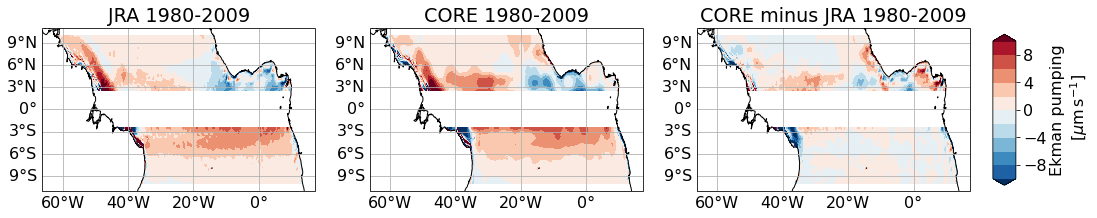

In [99]:
# Quick plot to show the results
tlim= ['1980','2009']
lw=2
linest='dashed'
c_vmin,c_vmax,levs=-10,10,11

# tau_curl_AM = tau_curl.sel(time_counter=slice('1980','2009')).mean('time_counter')
w_ek_1980_2009 = w_ek.w_ek.sel(time_counter=slice(*tlim)).mean('time_counter')

data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3),subplot_kw={'projection': ccrs.PlateCarree()})

im = plot_results(w_ek_1980_2009,'JRA',data_crs,axes[0],c_vmin,c_vmax,levs)
im = plot_results(w_ek_1980_2009,'CORE',data_crs,axes[1],c_vmin,c_vmax,levs)
im = plot_results(w_ek_1980_2009,'DIFF',data_crs,axes[2],c_vmin,c_vmax,levs)

axes[0].set_title('JRA 1980-2009')
axes[1].set_title('CORE 1980-2009')
axes[2].set_title('CORE minus JRA 1980-2009')

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb =fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label('Ekman pumping\n [$\mu$m$\,$s$^{-1}$]')

plt.savefig(out_dir_fig+f'INALT20_w_ek_maps_mean_{tlim[0]}_{tlim[1]}.png',dpi=300, bbox_inches='tight')

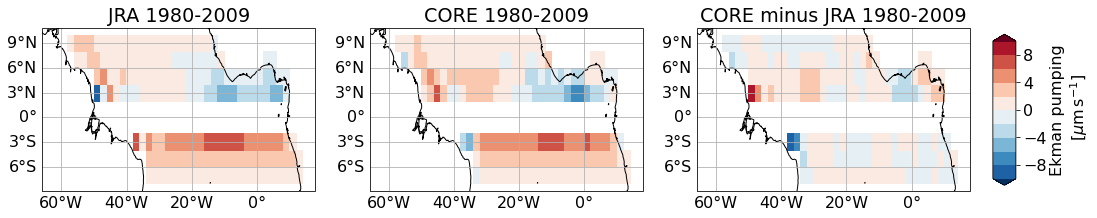

In [78]:
# Quick plot to show the results
tlim= ['1980','2009']
lw=2
linest='dashed'
c_vmin,c_vmax,levs=-10,10,11

# tau_curl_AM = tau_curl.sel(time_counter=slice('1980','2009')).mean('time_counter')
w_ek_1980_2009_2deg = w_ek_2deg.w_ek.sel(time_counter=slice(*tlim)).mean('time_counter')

data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3),subplot_kw={'projection': ccrs.PlateCarree()})

im = plot_results(w_ek_1980_2009_2deg,'JRA',data_crs,axes[0],c_vmin,c_vmax,levs)
im = plot_results(w_ek_1980_2009_2deg,'CORE',data_crs,axes[1],c_vmin,c_vmax,levs)
im = plot_results(w_ek_1980_2009_2deg,'DIFF',data_crs,axes[2],c_vmin,c_vmax,levs)

axes[0].set_title('JRA 1980-2009')
axes[1].set_title('CORE 1980-2009')
axes[2].set_title('CORE minus JRA 1980-2009')

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb =fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label('Ekman pumping\n [$\mu$m$\,$s$^{-1}$]')

plt.savefig(out_dir_fig+f'2deg_INALT20_w_ek_maps_mean_{tlim[0]}_{tlim[1]}.png',dpi=300, bbox_inches='tight')

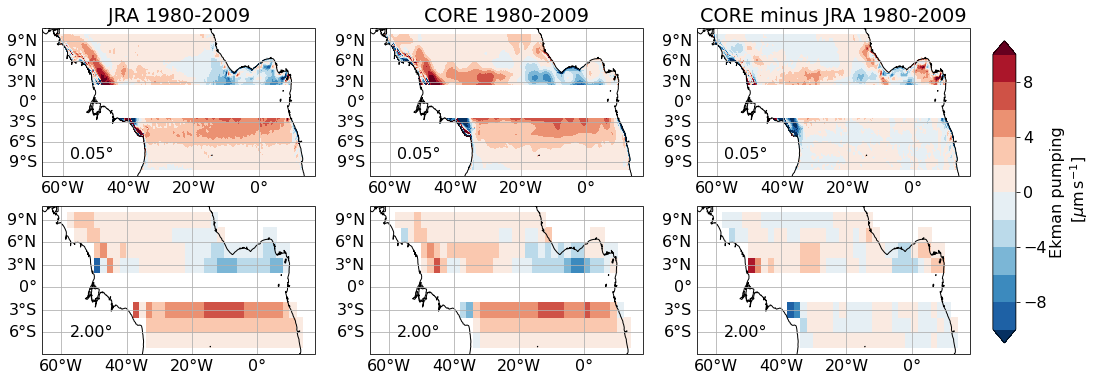

In [97]:
# Quick plot to show the results
tlim= ['1980','2009']
lw=2
linest='dashed'
c_vmin,c_vmax,levs=-10,10,11

# tau_curl_AM = tau_curl.sel(time_counter=slice('1980','2009')).mean('time_counter')
w_ek_1980_2009 = w_ek.w_ek.sel(time_counter=slice(*tlim)).mean('time_counter')
w_ek_1980_2009_2deg = w_ek_2deg.w_ek.sel(time_counter=slice(*tlim)).mean('time_counter')

data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,6),subplot_kw={'projection': ccrs.PlateCarree()})

im = plot_results(w_ek_1980_2009,'JRA',data_crs,axes[0,0],c_vmin,c_vmax,levs)
im = plot_results(w_ek_1980_2009,'CORE',data_crs,axes[0,1],c_vmin,c_vmax,levs)
im = plot_results(w_ek_1980_2009,'DIFF',data_crs,axes[0,2],c_vmin,c_vmax,levs)

im = plot_results(w_ek_1980_2009_2deg,'JRA',data_crs,axes[1,0],c_vmin,c_vmax,levs)
im = plot_results(w_ek_1980_2009_2deg,'CORE',data_crs,axes[1,1],c_vmin,c_vmax,levs)
im = plot_results(w_ek_1980_2009_2deg,'DIFF',data_crs,axes[1,2],c_vmin,c_vmax,levs)

for i,ax in enumerate(axes[0,:]):
    ax.text(0.1, 0.1, '0.05°', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

for i,ax in enumerate(axes[1,:]):
    ax.text(0.1, 0.1, '2.00°', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

axes[0,0].set_title('JRA 1980-2009')
axes[0,1].set_title('CORE 1980-2009')
axes[0,2].set_title('CORE minus JRA 1980-2009')

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb =fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label('Ekman pumping\n [$\mu$m$\,$s$^{-1}$]')

plt.savefig(out_dir_fig+f'2deg_vs_high_INALT20_w_ek_maps_mean_{tlim[0]}_{tlim[1]}.png',dpi=300, bbox_inches='tight')

In [104]:
tlim= ['1980','2009']
w_ek_clim =  w_ek.w_ek.sel(time_counter=slice(*tlim)).groupby('time_counter.month').mean('time_counter').compute()
w_ek_2deg_clim =  w_ek_2deg.w_ek.sel(time_counter=slice(*tlim)).groupby('time_counter.month').mean('time_counter').compute()

w_ek_clim.to_netcdf(f'{out_dir_data}1_INALT20_w_ek_mm_clim_{tlim[0]}_{tlim[1]}.nc')
w_ek_2deg_clim.to_netcdf(f'{out_dir_data}2deg_INALT20_w_ek_mm_clim_{tlim[0]}_{tlim[1]}.nc')

w_ek_anom = w_ek-w_ek_clim
w_ek_2deg_anom = w_ek_2deg-w_ek_2deg_clim

In [91]:
w_ek_seas =  w_ek.w_ek.sel(time_counter=slice(*tlim)).groupby('time_counter.season').mean('time_counter').compute()
w_ek_2deg_seas =  w_ek_2deg.w_ek.sel(time_counter=slice(*tlim)).groupby('time_counter.season').mean('time_counter').compute()

In [81]:
def plot_clim(w_ek_clim,row='month'):
    with xr.set_options(keep_attrs=True):
        dummy = xr.concat([w_ek_clim,w_ek_clim.diff('forcings')],
                          'forcings')
    dummy.coords['forcings'] = (['forcings'],['JRA','CORE','JRA-CORE'],)


    c_vmin,c_vmax,levs=-10,10,11
    dummy.plot(
            x='lon',y='lat',col='forcings',row=row,
            aspect=1.2, size=4,
            levels=levs,vmin=c_vmin,vmax=c_vmax,
            cmap=co.cm.balance)

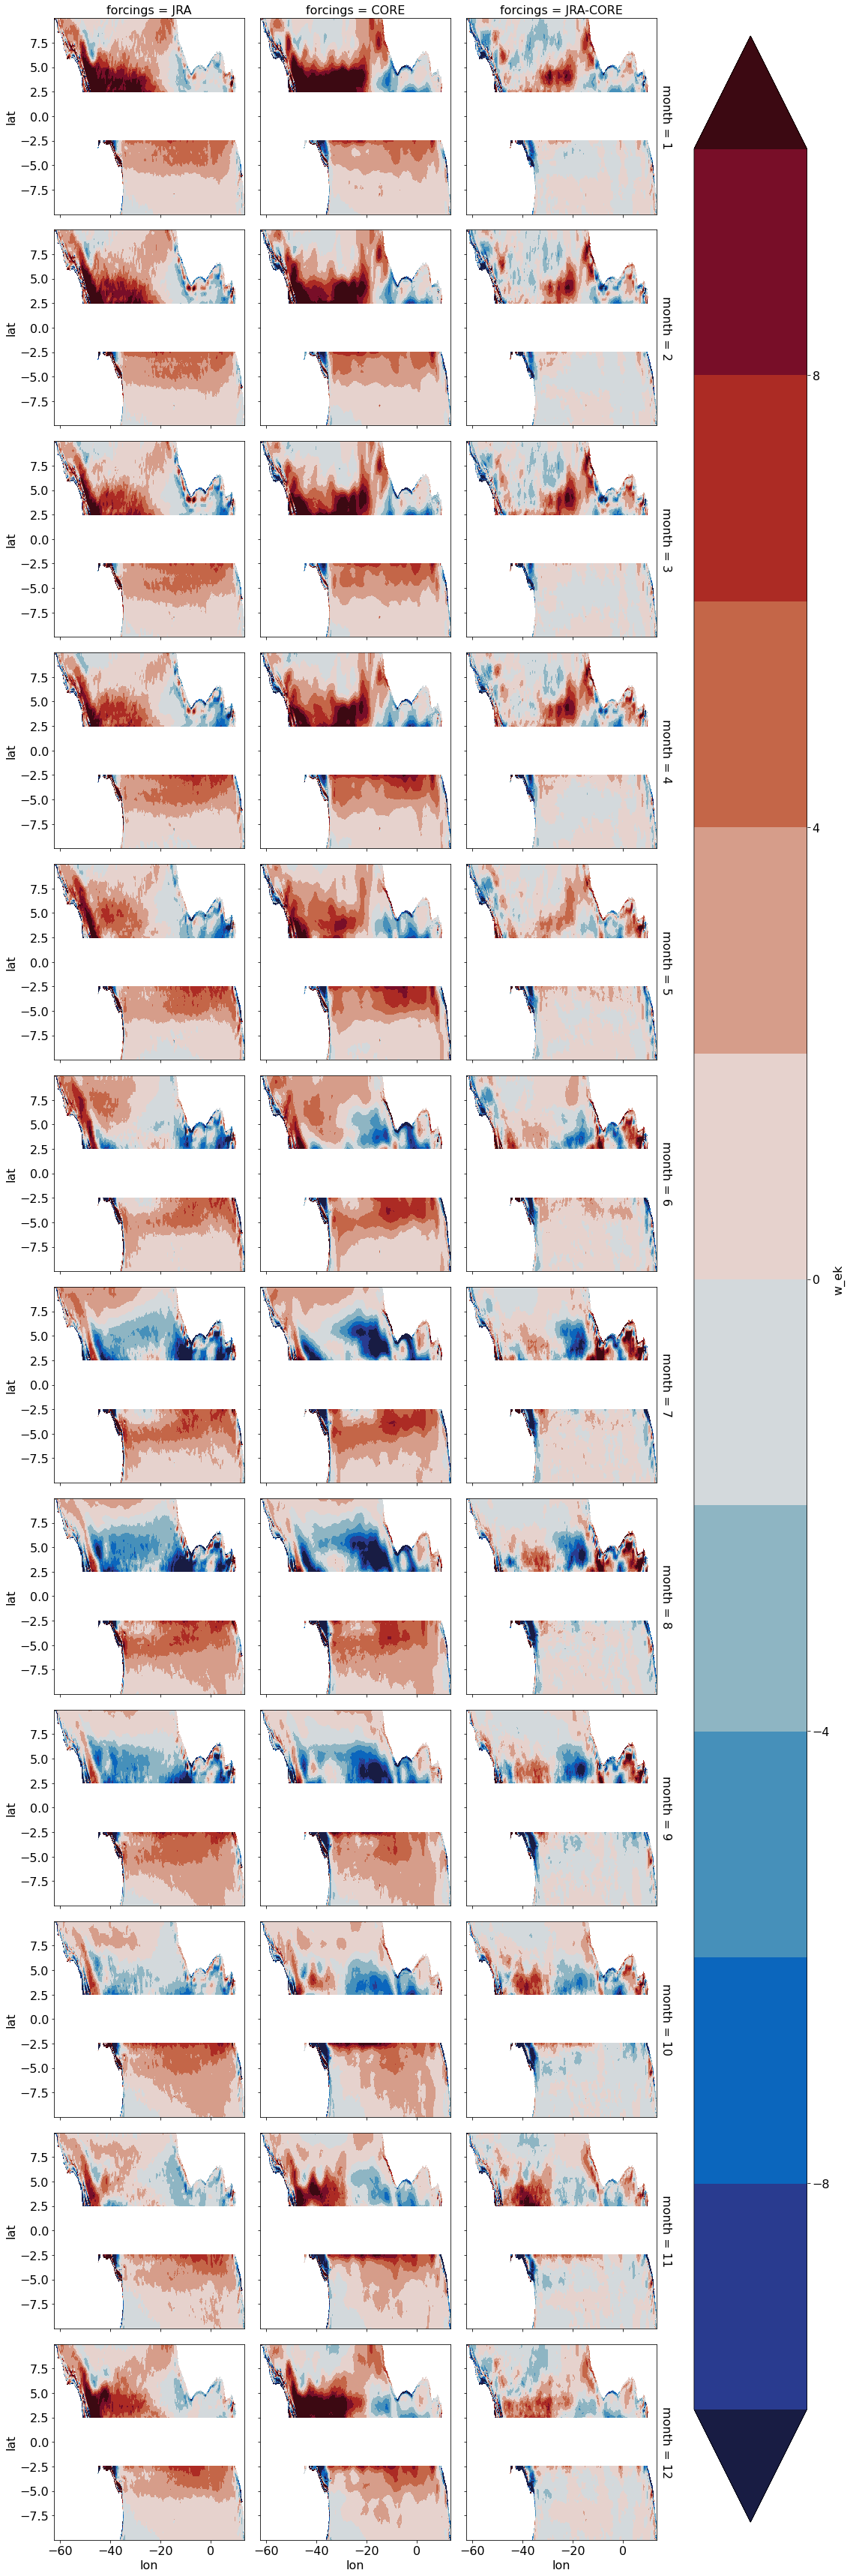

In [82]:
plot_clim(w_ek_clim)

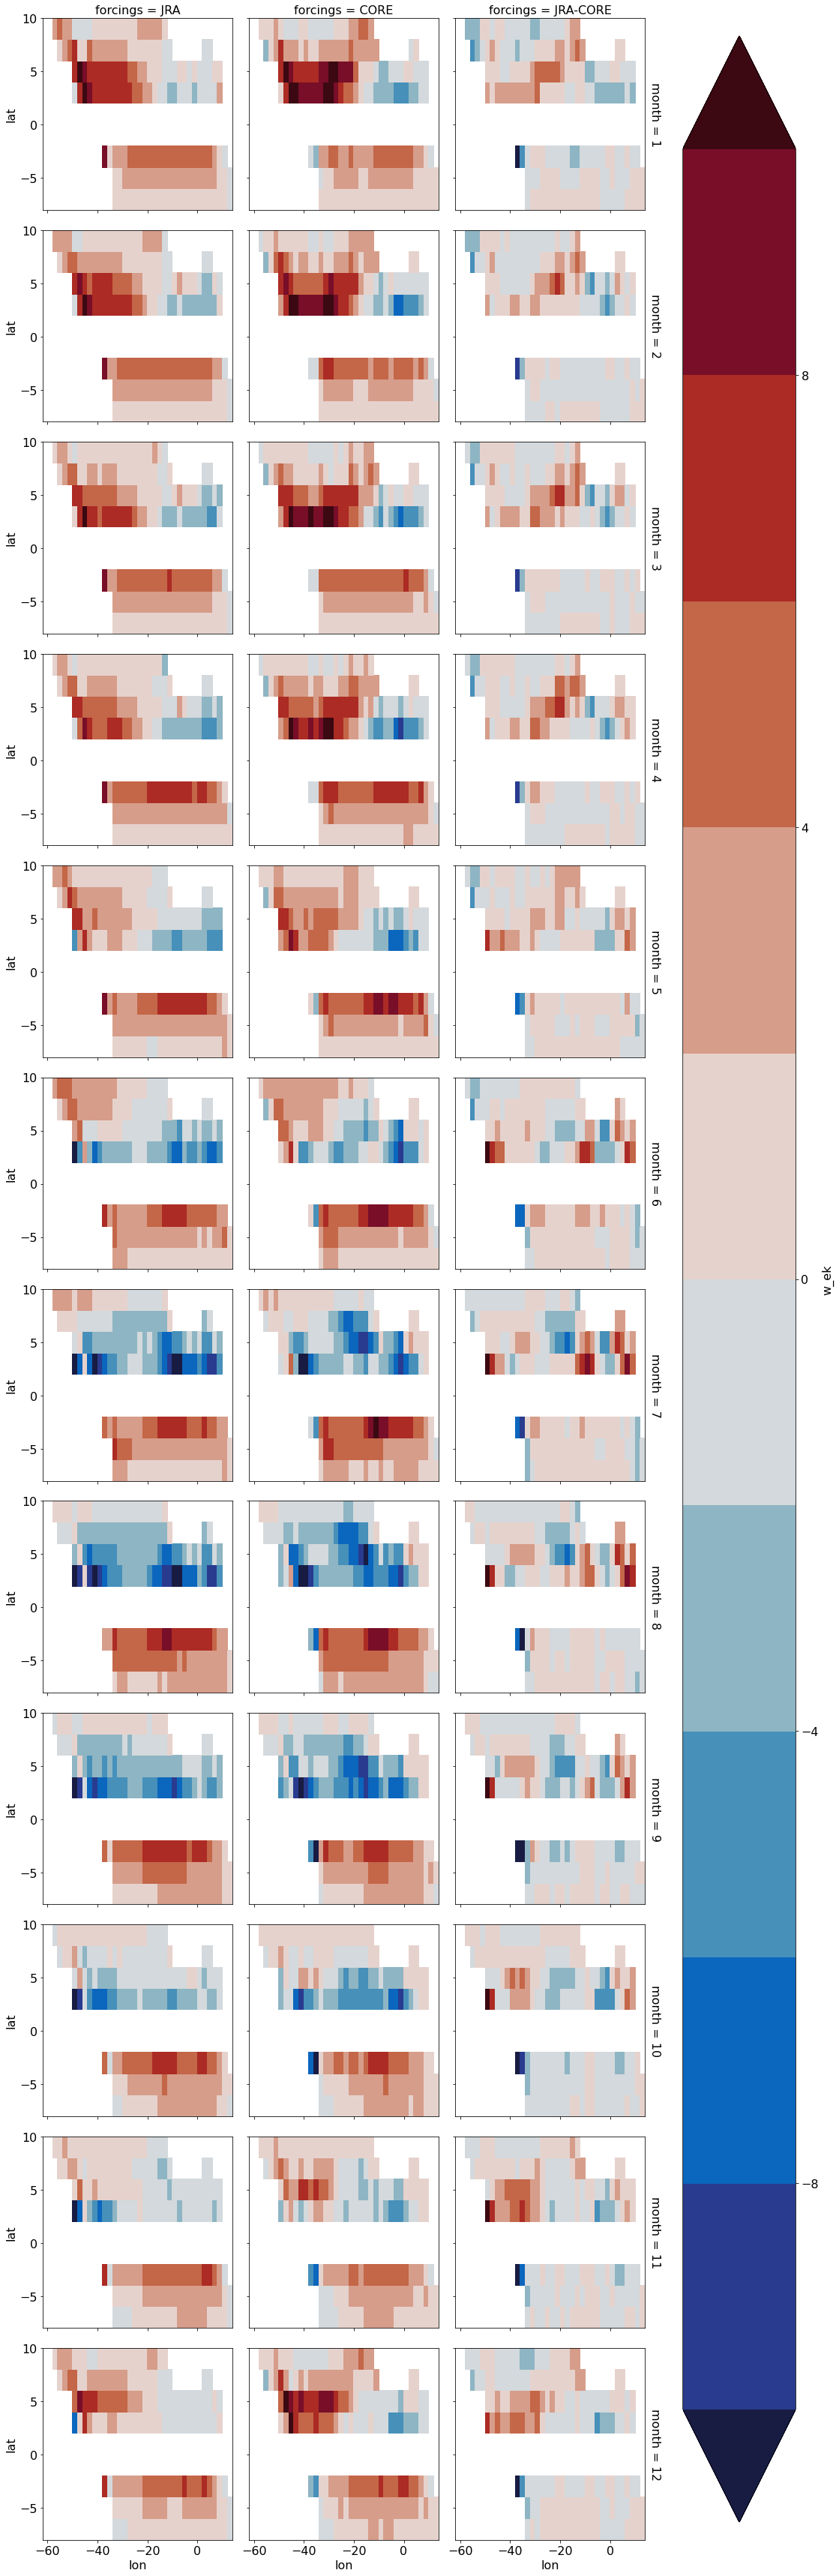

In [83]:
plot_clim(w_ek_2deg_clim)

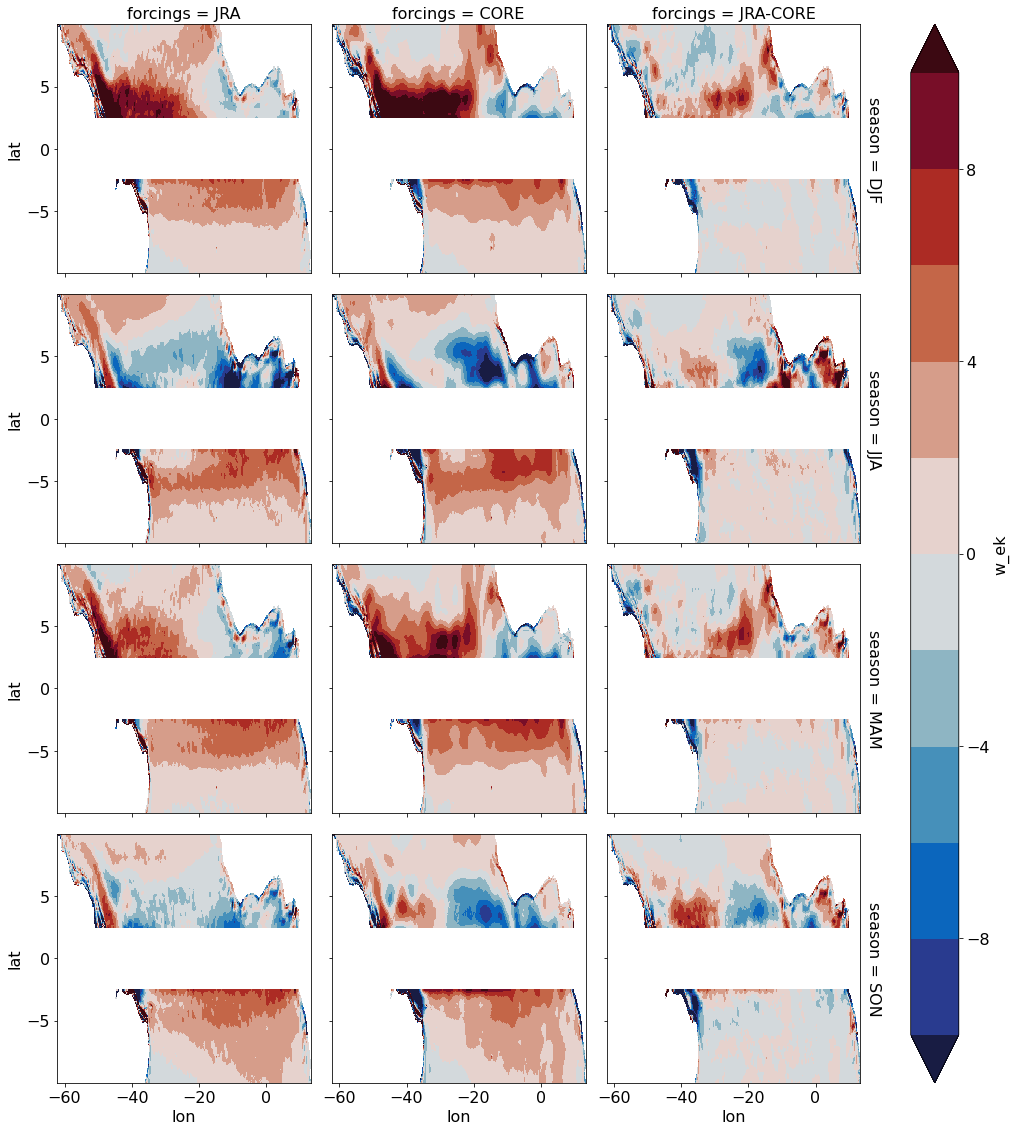

In [84]:
plot_clim(w_ek_seas,row='season')

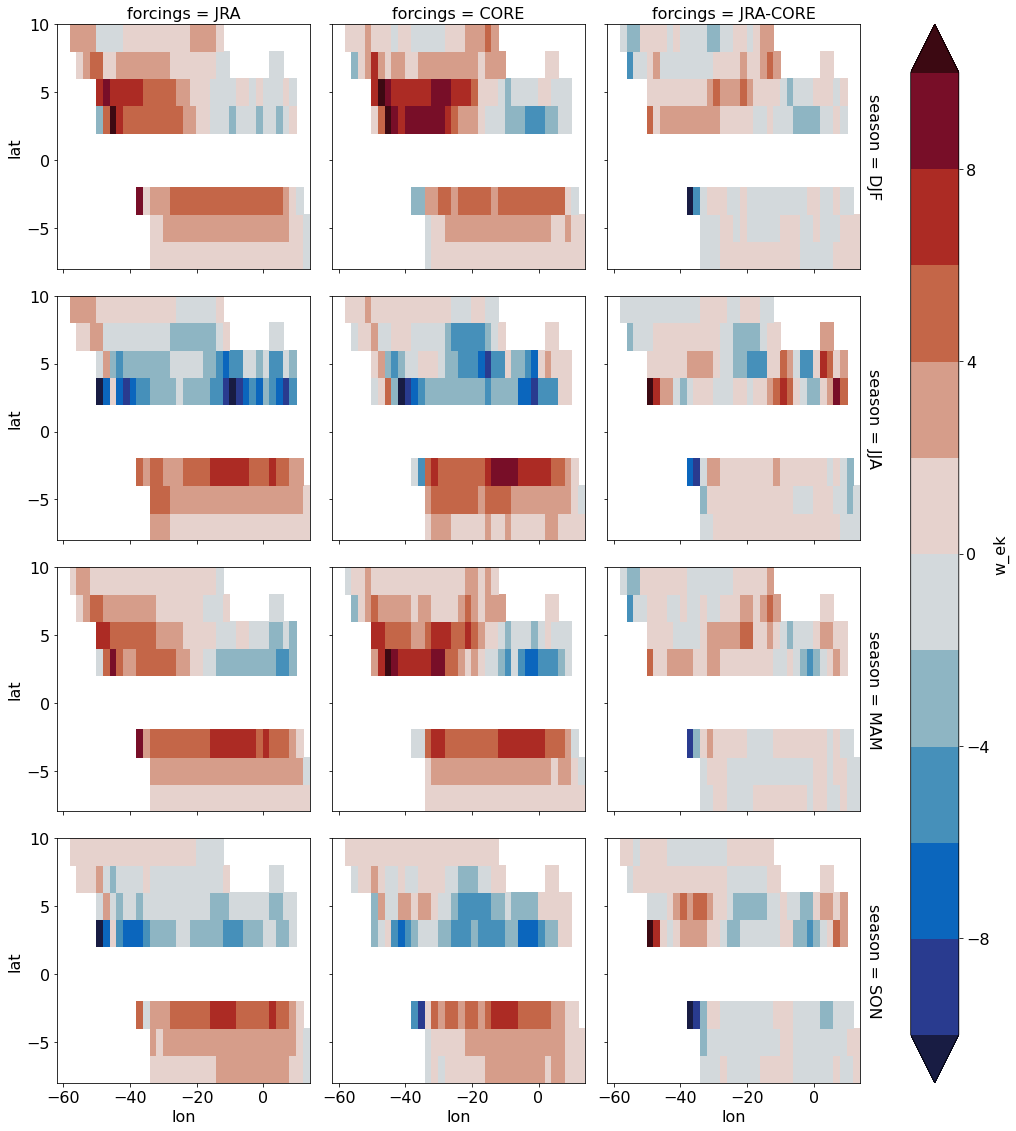

In [85]:
plot_clim(w_ek_2deg_seas,row='season')

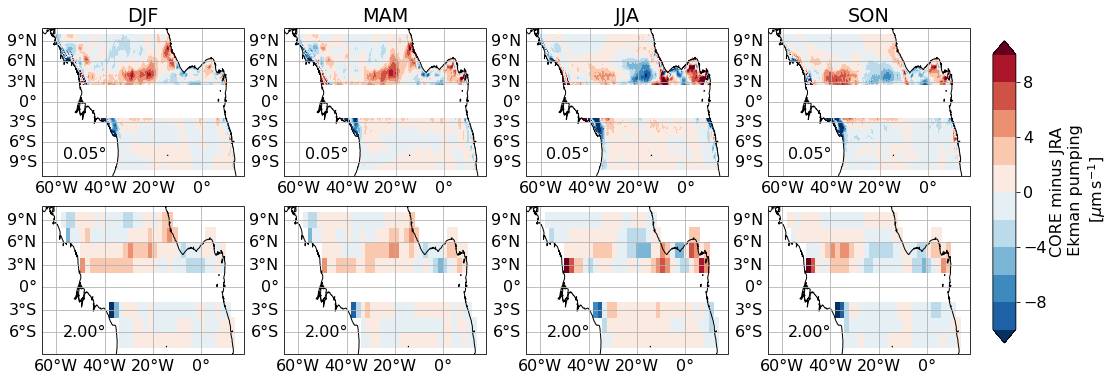

In [101]:
lw=2
linest='dashed'
c_vmin,c_vmax,levs=-10,10,11
season = ['DJF','MAM','JJA','SON']

data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6),subplot_kw={'projection': ccrs.PlateCarree()})

for i,ax in enumerate(axes[0,:]):
    im = plot_results(w_ek_seas.sel(season=season[i]),'DIFF',data_crs,ax,c_vmin,c_vmax,levs)
    ax.set_title(w_ek_seas.sel(season=season[i]).season.values)
    ax.text(0.1, 0.1, '0.05°', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

for i,ax in enumerate(axes[1,:]):
    im = plot_results(w_ek_2deg_seas.sel(season=season[i]),'DIFF',data_crs,ax,c_vmin,c_vmax,levs)
    ax.text(0.1, 0.1, '2.00°', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)


fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb =fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label('CORE minus JRA\n Ekman pumping\n [$\mu$m$\,$s$^{-1}$]')
plt.savefig(out_dir_fig+f'2deg_vs_high_INALT20_w_ek_maps_DIFF_season_{tlim[0]}_{tlim[1]}.png',dpi=300, bbox_inches='tight')